In [1]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import hydra
from hydra import initialize, compose
from omegaconf import OmedgaConf
initialize("./configs")

from sklearn.preprocessing import Binarizer
import tensorflow as tf
from tensorflow import keras

from utils.vision.transformation import rle_encode
from training import prepare_X_and_y

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_PARENT = pathlib.Path("__file__").absolute().parents[0]
PATH_CACHE_DATA = PATH_PARENT.joinpath(cfg.project_setup.paths.data.PREPROCESSED_CACHE)
PATH_MODEL = PATH_PARENT.joinpath("outputs", "2022-02-11", "05-54-14", "model")


In [3]:
# load trained model & trainings data
model = keras.models.load_model(PATH_MODEL)

with open(PATH_CACHE_DATA, 'rb') as f:
    train_data = pickle.load(f)
    
X, y = prepare_X_and_y(train_data)

In [5]:
## Finding optimal threshold for creating a binary mask
with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
    preds = model.predict(X)

threshold_ranges = np.arange(0.25, 0.76, 0.05)

accuracies = []

for threshold in threshold_ranges:
    pred_mask = Binarizer(threshold = threshold).transform(preds.reshape(-1, 1)).reshape(preds.shape)
    accuracies.append((pred_mask == y).sum() / pred_mask.size)

threshold_results_df = pd.DataFrame({
    'threshold': threshold_ranges,
    'accuracy': accuracies
})

threshold_results_df.round(3).sort_values('accuracy', ascending = False)

,threshold,accuracy
2,0.35,0.900
3,0.40,0.900
4,0.45,0.898
1,0.30,0.896
5,0.50,0.895
6,0.55,0.892
7,0.60,0.890
8,0.65,0.889
9,0.70,0.889
10,0.75,0.888


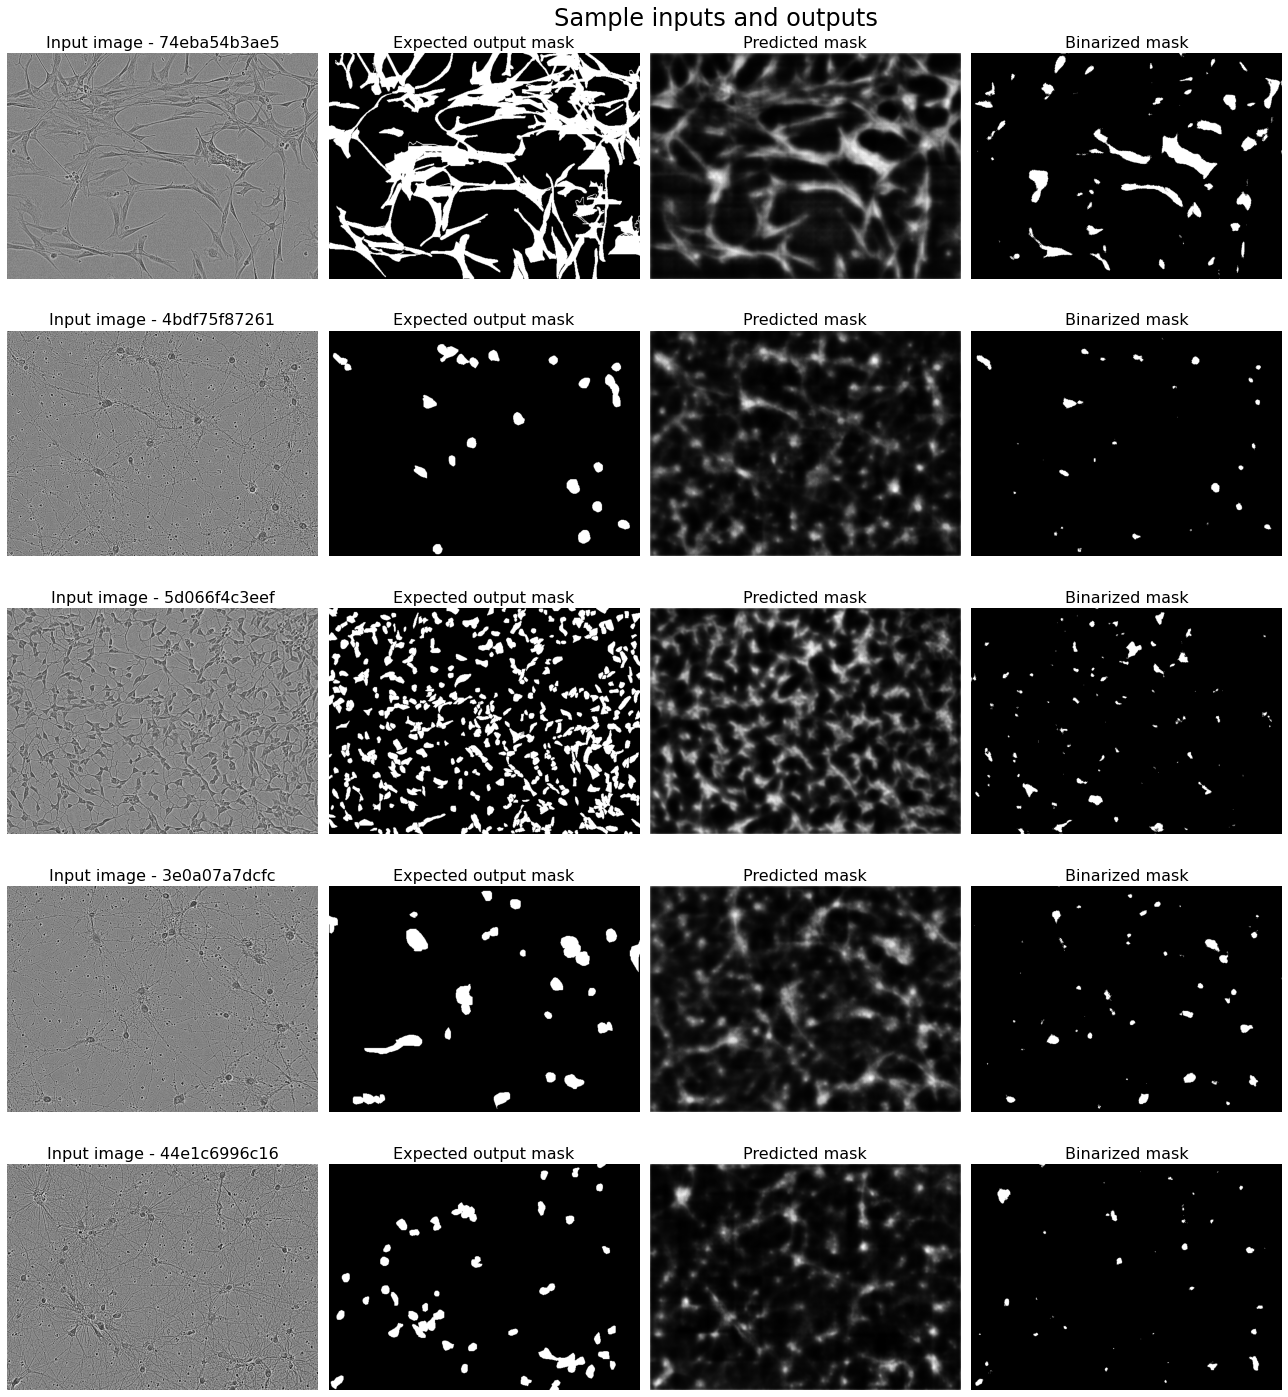

In [27]:
# Visualizing Predictions with optimal threshold for creating binary mask
num_preds = 5
sample_pred_ids = np.random.randint(len(X), size = num_preds)

pred_y = model.predict(X[sample_pred_ids])
pred_y_mask = Binarizer(threshold = 0.4).transform(pred_y.reshape(-1, 1)).reshape(pred_y.shape)

plt.figure(figsize = (20 , 20))
for i in range(num_preds):
    
    image_id = list(train_data.keys())[sample_pred_ids[i]]
    
    
    plt.subplot(num_preds, 4, (4 * i) + 1)
    plt.imshow(X[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title(f'Input image - {image_id}', fontsize = 16)

    
    plt.subplot(num_preds, 4, (4 * i) + 2)
    plt.imshow(y[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title('Expected output mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 3)
    plt.imshow(pred_y[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Predicted mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 4)
    plt.imshow(pred_y_mask[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Binarized mask', fontsize = 16)
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout(rect = [0, 0, 0.90, 1])
plt.show()

In [28]:
img_ids = []
rle_encondings = []
for i in range(num_preds):
    
    img_id = list(train_data.keys())[sample_pred_ids[i]]
    img_ids.append(img_id)
    
    rle_encoding = rle_encode(pred_y_mask[i])
    rle_encondings.append(rle_encoding)

sample_submission = pd.DataFrame({
    'id': img_ids,
    'predicted': rle_encondings
})

sample_submission

,id,predicted
0,74eba54b3ae5,206 1 208 1 210 1 212 1 214 1 222 1 472 7 480 ...
1,4bdf75f87261,13105 1 13810 1 15219 1 29825 1 30525 7 31229 ...
2,5d066f4c3eef,282 1 284 5 988 1 990 1 992 1 6768 1 7472 6 81...
3,3e0a07a7dcfc,198 1 200 1 904 1 13033 1 13035 1 13734 2 1373...
4,44e1c6996c16,156 13 860 1 862 11 1570 1 1572 3 2272 1 2274 ...
